In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torch.autograd import Variable
from torchvision import transforms
import cv2
import matplotlib.pyplot as plt
import glob
import os
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
device

device(type='mps')

In [3]:
# 세로 이미지에 좌우 여백을 추가 (세로 사이즈로 통일)
def add_padding_left_right(img:np.ndarray, color) -> np.ndarray:
    padding = (img.shape[0] - img.shape[1]) // 2
    img = cv2.copyMakeBorder(img, 0, 0, padding, padding, cv2.BORDER_CONSTANT, value=color)
    return img

# 이미지 회전
# bg_color -> 회전하고 남은 여백을 채울 색깔
def rotate_img(img:np.ndarray, degree, bg_color) -> np.ndarray:
    h, w = img.shape[:2]
    cy, cx = (h // 2), (w // 2)
    M = cv2.getRotationMatrix2D((cx, cy), degree, 1.0)
    img = cv2.warpAffine(img, M, (w, h), borderValue=bg_color)
    return img

(1024, 1024, 3)


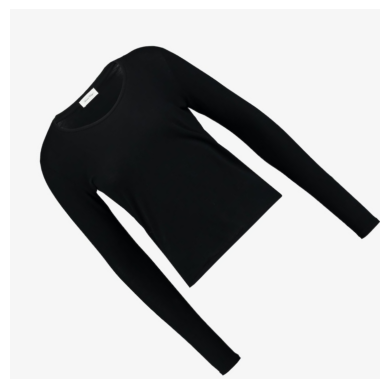

In [4]:
# 데이터 미리보기 

img = cv2.imread('./cloth/00006_00.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = add_padding_left_right(img, color=(246, 246, 246))
img = rotate_img(img, 45, bg_color=(246, 246, 246))

print(img.shape)
plt.imshow(img)
plt.axis('off')
plt.show()




In [5]:
image_files = np.array([os.path.join('./cloth', file) for file in os.listdir('./cloth')])
mask = np.random.choice(len(image_files), int(len(image_files) * 0.2), replace=False)

train_data = [] # (label, img)
test_data = []

for i in range(len(image_files)):
    img = cv2.imread(image_files[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = add_padding_left_right(img, color=(246, 246, 246))

    degrees = np.random.choice(range(360), 1, replace=False)
    for degree in degrees:
        rotated_img = rotate_img(img, degree, bg_color=(246, 246, 246))

        if i in mask:
            test_data.append((rotated_img, degree))
        else:
            train_data.append((rotated_img, degree))

print(len(train_data), len(test_data))

1626 406


<Axes: ylabel='Count'>

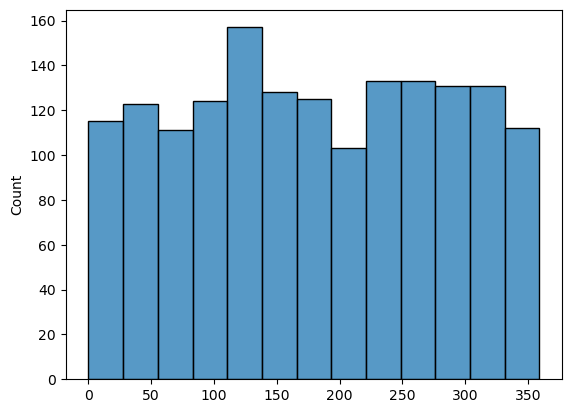

In [6]:
sns.histplot([x[1] for x in train_data])

In [7]:
class CustomDataset(Dataset):
    def __init__(self, data_list) -> None:
        super().__init__()
        self.data = data_list
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        sample = torch.tensor(self.data[index][0]).float()
        label = torch.tensor(self.data[index][1]).float()
        return sample, label

train_dataset = CustomDataset(train_data)
test_dataset = CustomDataset(test_data)

In [8]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

In [9]:
for data in train_loader:
    x, y = data
    print(x.shape, y.shape)
    break

torch.Size([16, 1024, 1024, 3]) torch.Size([16])


In [10]:
x.view(-1, 3, 1024, 1024).shape

torch.Size([16, 3, 1024, 1024])

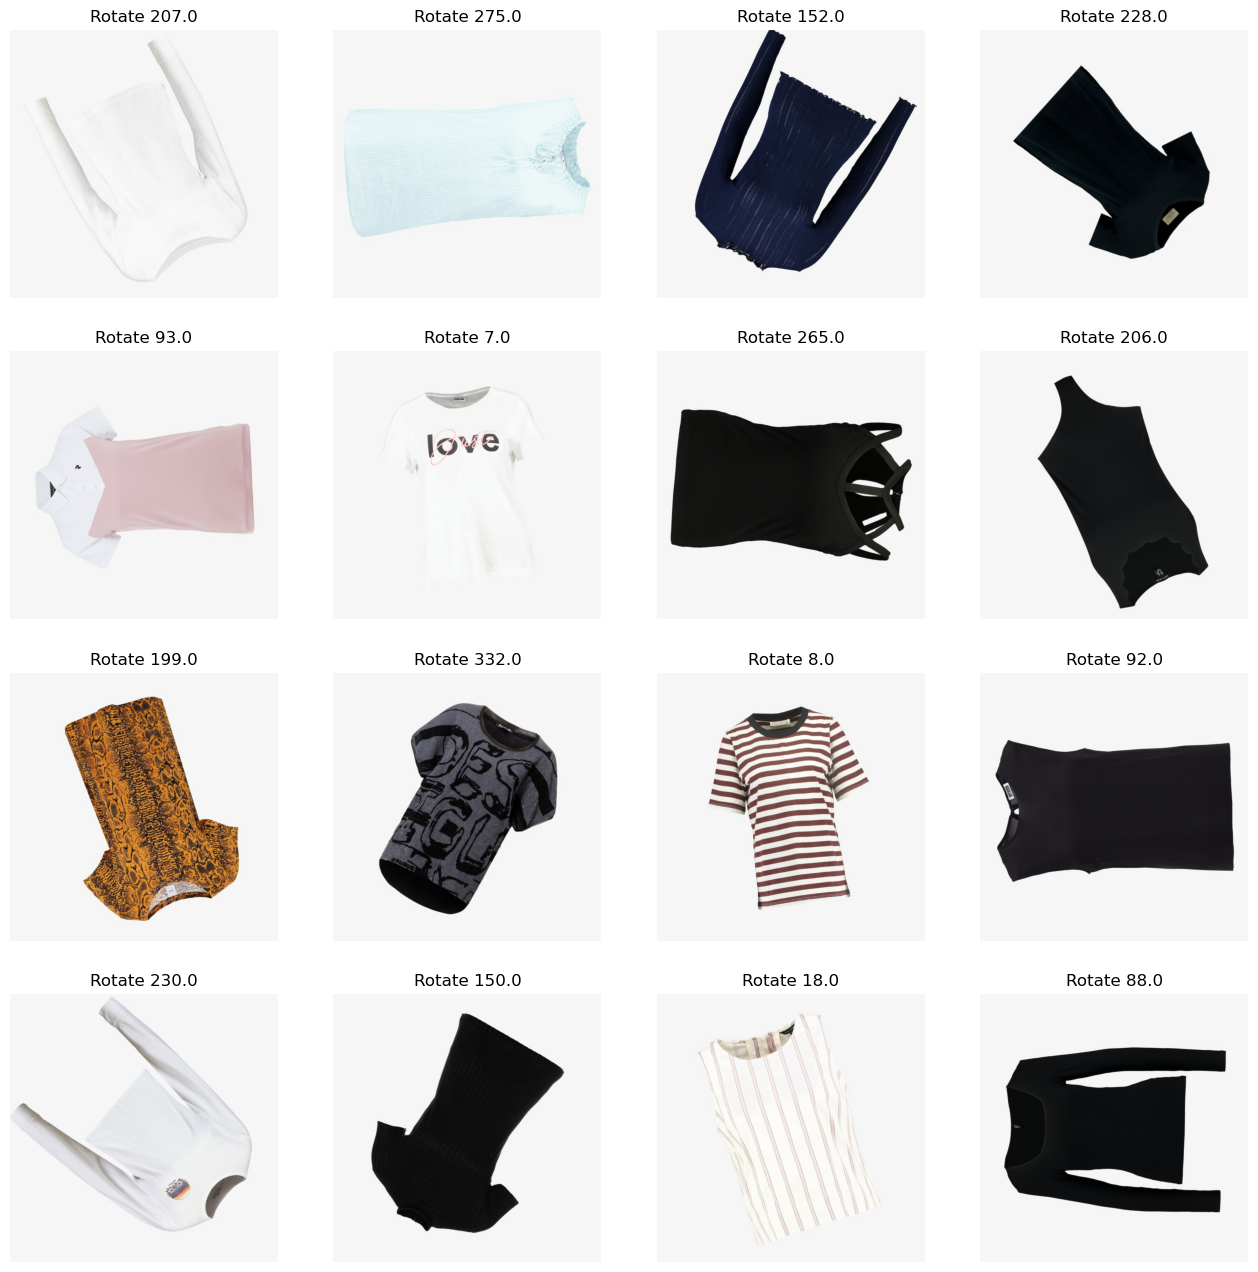

In [11]:
data = next(iter(test_loader))

fig = plt.figure(figsize=(16, 16))
colums = 4
rows = 4
for i in range(1, colums * rows + 1):
    img = test_dataset[i][0].int() # 28x28 이미지
    fig.add_subplot(rows, colums, i)
    plt.title(f'Rotate {test_dataset[i][1]}')
    plt.axis('off')
    plt.imshow(img, cmap='gray')

plt.show()

In [12]:
class ClothAngleCorrection(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Conv2d(64, 128, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.fc = nn.Linear(64, 1)
    
    def forward(self, x:torch.Tensor):
        out = self.layer(x)
        out = self.fc(out)
        return out
        

In [13]:
model = ClothAngleCorrection()
model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model

ClothAngleCorrection(
  (layer): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.3, inplace=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

In [14]:
# 모델 학습

num_epochs = 10
count = 0

loss_list = []
iter_list = []
acc_list = []

pred_list = []
labels_list = []

for epoch in range(num_epochs):
    for x_train, y_train in train_loader:
        x_train, y_train = x_train.to(device), y_train.to(device)
        x_train = Variable(x_train.view(-1, 3, 1024, 1024))
        y_train = Variable(y_train)

        outputs = model(x_train)
        loss = criterion(outputs, y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        count += 1

        if count % 50 == 0:
            total = 0
            correct = 0
            for x_test, y_test in test_loader:
                x_test, y_test = x_test.to(device), y_test.to(device)
                labels_list.append(y_test)
                x_test = Variable(x_test)
                outputs = model(x_test)
                preds = torch.max(outputs, 1)[1].to(device)
                pred_list.append(preds)
                correct += (preds == y_test).sum()
                total += len(y_test)

            acc = correct * 100 / total
            loss_list.append(loss.data)
            iter_list.append(count)
            acc_list.append(acc)
        
        if count % 500 == 0:
            print(f'Iteration: {count}, Loss:{loss.data}, Accuracy:{acc}')

RuntimeError: MPS backend out of memory (MPS allocated: 12.97 GB, other allocations: 4.18 GB, max allowed: 18.13 GB). Tried to allocate 3.98 GB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).